# 机器学习练习 7 - K-means 和PCA（主成分分析）

在本练习中，我们将实现K-means聚类，并使用它来压缩图像。 我们将从一个简单的2D数据集开始，以了解K-means是如何工作的，然后我们将其应用于图像压缩。 我们还将对主成分分析进行实验，并了解如何使用它来找到面部图像的低维表示。

## K-means 聚类

我们将实施和应用K-means到一个简单的二维数据集，以获得一些直观的工作原理。 K-means是一个迭代的，无监督的聚类算法，将类似的实例组合成簇。 该算法通过猜测每个簇的初始聚类中心开始，然后重复将实例分配给最近的簇，并重新计算该簇的聚类中心。 我们要实现的第一部分是找到数据中每个实例最接近的聚类中心的函数。

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat


In [37]:
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    
    for i in range(m):
        min_dist = 1000000
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j,:]) ** 2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j
    
    return idx

In [38]:
# 让我们来测试这个函数，以确保它的工作正常。 我们将使用练习中提供的测试用例。
data = loadmat('ex7-kmeans and PCA\data\ex7data2.mat')


In [39]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Nov 16 00:48:22 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 1.84207953,  4.6075716 ],
        [ 5.65858312,  4.79996405],
        [ 6.35257892,  3.2908545 ],
        [ 2.90401653,  4.61220411],
        [ 3.23197916,  4.93989405],
        [ 1.24792268,  4.93267846],
        [ 1.97619886,  4.43489674],
        [ 2.23454135,  5.05547168],
        [ 2.98340757,  4.84046406],
        [ 2.97970391,  4.80671081],
        [ 2.11496411,  5.37373587],
        [ 2.12169543,  5.20854212],
        [ 1.5143529 ,  4.77003303],
        [ 2.16979227,  5.27435354],
        [ 0.41852373,  4.88312522],
        [ 2.47053695,  4.80418944],
        [ 4.06069132,  4.99503862],
        [ 3.00708934,  4.67897758],
        [ 0.66632346,  4.87187949],
        [ 3.1621865 ,  4.83658301],
        [ 0.51155258,  4.91052923],
        [ 3.1342801 ,  4.96178114],
        [ 2.04974595,  5.6241395 ],
        [ 0.66582785,  5.243

In [42]:
X = data['X']
initial_centroids = initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

idx = find_closest_centroids(X, initial_centroids)
idx[0:10]

array([0., 2., 1., 0., 0., 0., 0., 0., 0., 0.])

输出与文本中的预期值匹配（记住我们的数组是从零开始索引的，而不是从一开始索引的，所以值比练习中的值低一个）。 接下来，我们需要一个函数来计算簇的聚类中心。 聚类中心只是当前分配给簇的所有样本的平均值。

In [43]:
data2 = pd.DataFrame(data.get('X'), columns=['X1', 'X2'])
data2.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


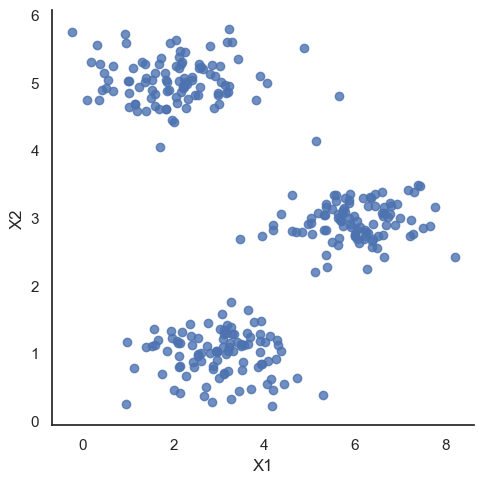

In [44]:
sb.set(context="notebook", style="white")
sb.lmplot('X1', 'X2', data=data2, fit_reg=False)
plt.show()

In [45]:
def compute_centroids(X, idx, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    
    for i in range(k):
        indices = np.where(idx == i)
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    return centroids

In [46]:
compute_centroids(X, idx, 3)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

此输出也符合练习中的预期值。 
下一部分涉及实际运行该算法的一些迭代次数和可视化结果。 
这个步骤是由于并不复杂，我将从头开始构建它。 为了运行算法，我们只需要在将样本分配给最近的簇并重新计算簇的聚类中心。

In [47]:
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
    
    return idx, centroids

In [48]:
idx, centroids = run_k_means(X, initial_centroids, 10)

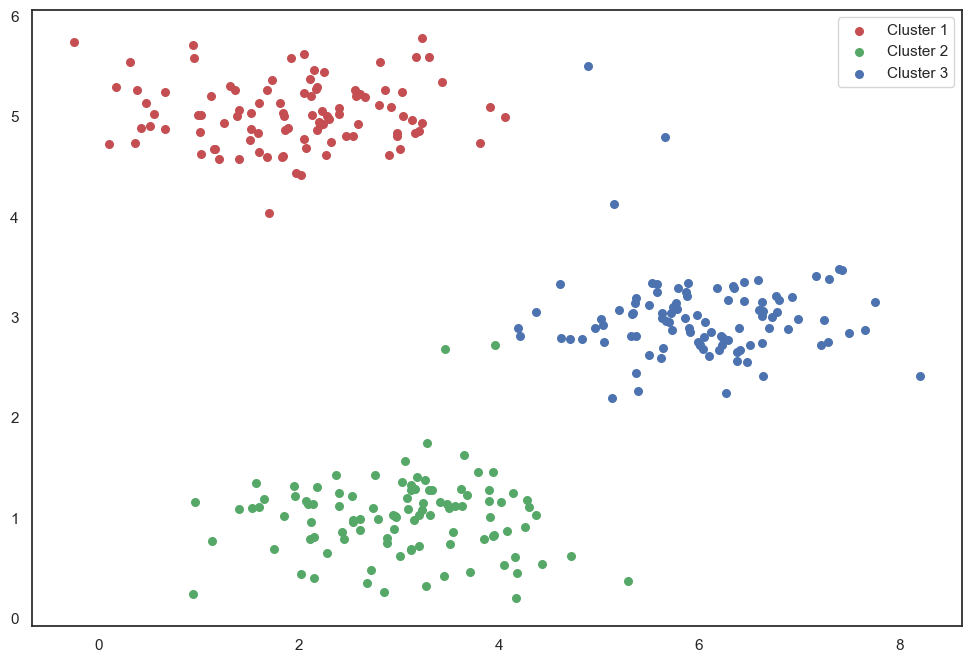

In [49]:
cluster1 = X[np.where(idx == 0)[0],:]
cluster2 = X[np.where(idx == 1)[0],:]
cluster3 = X[np.where(idx == 2)[0],:]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster 1')
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, color='g', label='Cluster 2')
ax.scatter(cluster3[:,0], cluster3[:,1], s=30, color='b', label='Cluster 3')
ax.legend()
plt.show()

In [50]:
# 我们跳过的一个步骤是初始化聚类中心的过程。 这可以影响算法的收敛。 我们的任务是创建一个选择随机样本并将其用作初始聚类中心的函数。
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)
    
    for i in range(k):
        centroids[i,:] = X[idx[i],:]
    
    return centroids

In [51]:
init_centroids(X, 3)

array([[3.23114248, 5.78429665],
       [5.91280273, 2.85631938],
       [2.05288518, 4.77958559]])

我们的下一个任务是将K-means应用于图像压缩。 从下面的演示可以看到，我们可以使用聚类来找到最具代表性的少数颜色，并使用聚类分配将原始的24位颜色映射到较低维的颜色空间。 

下面是我们要压缩的图像。

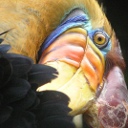

In [53]:
from IPython.display import Image
Image(filename='ex7-kmeans and PCA/data/bird_small.png')

In [54]:
# The raw pixel data has been pre-loaded for us so let's pull it in.

In [55]:
image_data = loadmat('ex7-kmeans and PCA/data/bird_small.mat')
image_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Jun  5 04:06:24 2012',
 '__version__': '1.0',
 '__globals__': [],
 'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ...,
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ...,
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ...,
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ...,
 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ...,
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ...,
         [ 80,  38,  40],
         [ 68,  39,  40],
     

In [56]:
A = image_data['A']
A.shape

(128, 128, 3)

In [57]:
# normalize value ranges
A = A / 255.

# reshape the array
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
X.shape

(16384, 3)

In [58]:
# randomly initialize the centroids
initial_centroids = init_centroids(X, 16)

# run the algorithm
idx, centroids = run_k_means(X, initial_centroids, 10)

# get the closest centroids one last time
idx = find_closest_centroids(X, centroids)

# map each pixel to the centroid value
X_recovered = centroids[idx.astype(int),:]
X_recovered.shape

(16384, 3)

In [59]:
# reshape to the original dimensions
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
X_recovered.shape

(128, 128, 3)

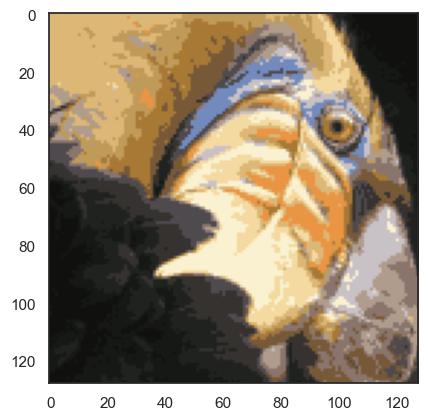

In [60]:
plt.imshow(X_recovered)
plt.show()

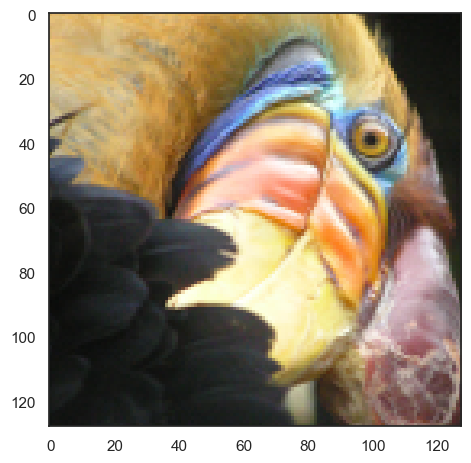

In [63]:
# 您可以看到我们对图像进行了压缩，但图像的主要特征仍然存在。 这就是K-means。 下面我们来用scikit-learn来实现K-means。
from skimage import io

# cast to float, you need to do this otherwise the color would be weird after clustring
pic = io.imread('ex7-kmeans and PCA/data/bird_small.png') / 255.
io.imshow(pic)
plt.show()

In [64]:
pic.shape

(128, 128, 3)

In [65]:
# serialize data
data = pic.reshape(128*128, 3)

In [66]:
data

array([[0.85882353, 0.70588235, 0.40392157],
       [0.90196078, 0.7254902 , 0.45490196],
       [0.88627451, 0.72941176, 0.43137255],
       ...,
       [0.25490196, 0.16862745, 0.15294118],
       [0.22745098, 0.14509804, 0.14901961],
       [0.20392157, 0.15294118, 0.13333333]])

In [67]:
data.shape

(16384, 3)

In [69]:
from sklearn.cluster import KMeans#导入kmeans库

model = KMeans(n_clusters=16, n_init=100)

In [70]:
model.fit(data)

KMeans(n_clusters=16, n_init=100)

In [71]:
centroids = model.cluster_centers_
print(centroids.shape)

C = model.predict(data)
print(C.shape)

(16, 3)
(16384,)


In [72]:
centroids[C].shape

(16384, 3)

In [73]:
compressed_pic = centroids[C].reshape((128,128,3))

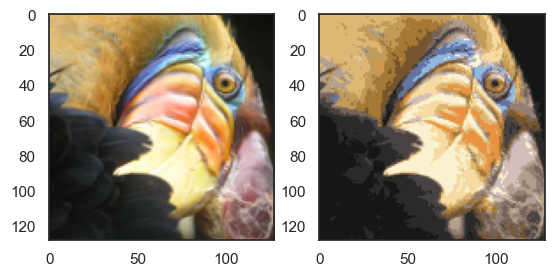

In [74]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()